# Diffusion Models for Tabular Data - Step by Step

This notebook walks through the core concepts of diffusion models, building up from basics.

## 1. What is Gaussian Noise?

**Gaussian noise** (also called "normal noise") is random numbers drawn from a normal distribution.

- Mean = 0 (centered around zero)
- Std = 1 (most values between -3 and +3)

It's called "Gaussian" after mathematician Carl Friedrich Gauss. This is the classic "bell curve" distribution.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti SUPER


Mean: 0.0072 (should be ~0)
Std:  0.9945 (should be ~1)
Min:  -3.9754
Max:  3.7457


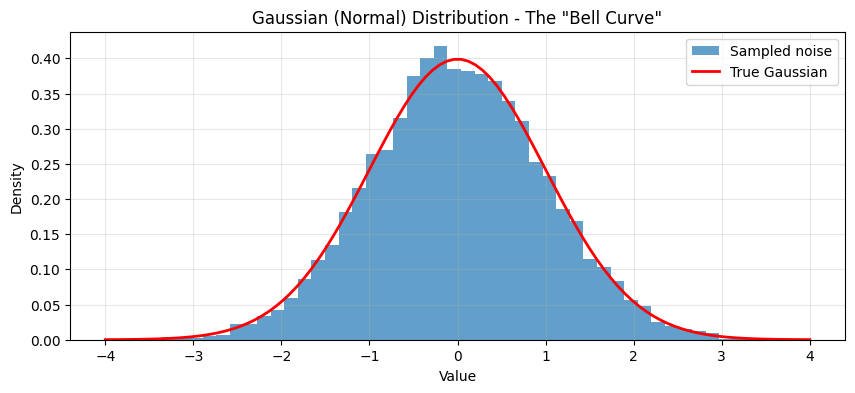

In [2]:
# Generate Gaussian noise
noise = torch.randn(10000)  # 10,000 random samples from N(0, 1)

print(f"Mean: {noise.mean():.4f} (should be ~0)")
print(f"Std:  {noise.std():.4f} (should be ~1)")
print(f"Min:  {noise.min():.4f}")
print(f"Max:  {noise.max():.4f}")

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(noise.numpy(), bins=50, density=True, alpha=0.7, label='Sampled noise')
x = np.linspace(-4, 4, 100)
plt.plot(x, np.exp(-x**2/2) / np.sqrt(2*np.pi), 'r-', lw=2, label='True Gaussian')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Gaussian (Normal) Distribution - The "Bell Curve"')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. The Core Idea of Diffusion

Diffusion models work in two phases:

### Forward Process (Destroy)
Gradually add noise to data until it becomes pure noise.

### Reverse Process (Create)
Learn to remove noise step by step, starting from pure noise.

**Analogy**: Imagine a drop of ink in water:
- Forward: The ink diffuses until the water is uniformly gray
- Reverse: We learn to "un-diffuse" and recover the original ink drop

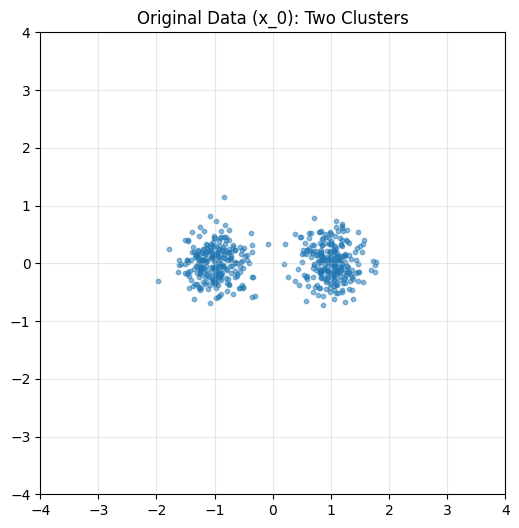

In [3]:
# Let's visualize this with a simple 2D example
# Create some structured data (two clusters)

np.random.seed(42)
n_points = 500

# Two clusters
cluster1 = np.random.randn(n_points // 2, 2) * 0.3 + np.array([-1, 0])
cluster2 = np.random.randn(n_points // 2, 2) * 0.3 + np.array([1, 0])
data = np.vstack([cluster1, cluster2])

x_0 = torch.tensor(data, dtype=torch.float32)

plt.figure(figsize=(6, 6))
plt.scatter(x_0[:, 0], x_0[:, 1], alpha=0.5, s=10)
plt.title('Original Data (x_0): Two Clusters')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.grid(True, alpha=0.3)
plt.show()

## 3. Forward Process: Adding Noise

The forward process adds noise according to:

$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$

Where:
- $x_0$ = original data
- $x_t$ = noisy data at timestep $t$
- $\epsilon$ = Gaussian noise (random)
- $\bar{\alpha}_t$ = how much signal remains (decreases over time)

At $t=0$: $\bar{\alpha}_0 \approx 1$ → mostly signal, little noise  
At $t=T$: $\bar{\alpha}_T \approx 0$ → mostly noise, no signal

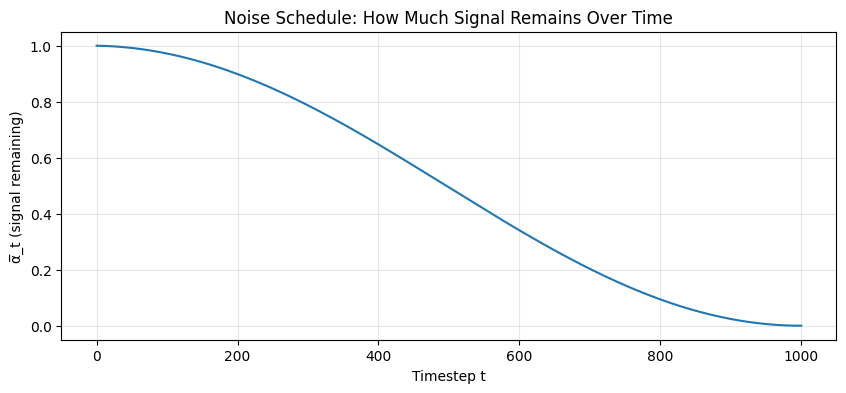

At t=0:   α̅ = 0.9998 (99.9% signal)
At t=500: α̅ = 0.4938 (50% signal)
At t=1000: α̅ = 0.000000 (0% signal)


In [4]:
def get_alpha_bar(t, T=1000):
    """Cosine schedule for alpha_bar (how much signal remains)."""
    s = 0.008
    return np.cos((t/T + s) / (1 + s) * np.pi / 2) ** 2

def add_noise(x_0, t, T=1000):
    """Add noise to data at timestep t."""
    alpha_bar = get_alpha_bar(t, T)
    noise = torch.randn_like(x_0)
    
    x_t = np.sqrt(alpha_bar) * x_0 + np.sqrt(1 - alpha_bar) * noise
    return x_t, noise

# Visualize the schedule
timesteps = np.arange(0, 1001)
alpha_bars = [get_alpha_bar(t) for t in timesteps]

plt.figure(figsize=(10, 4))
plt.plot(timesteps, alpha_bars)
plt.xlabel('Timestep t')
plt.ylabel('α̅_t (signal remaining)')
plt.title('Noise Schedule: How Much Signal Remains Over Time')
plt.grid(True, alpha=0.3)
plt.show()

print(f"At t=0:   α̅ = {get_alpha_bar(0):.4f} (99.9% signal)")
print(f"At t=500: α̅ = {get_alpha_bar(500):.4f} (50% signal)")
print(f"At t=1000: α̅ = {get_alpha_bar(1000):.6f} (0% signal)")

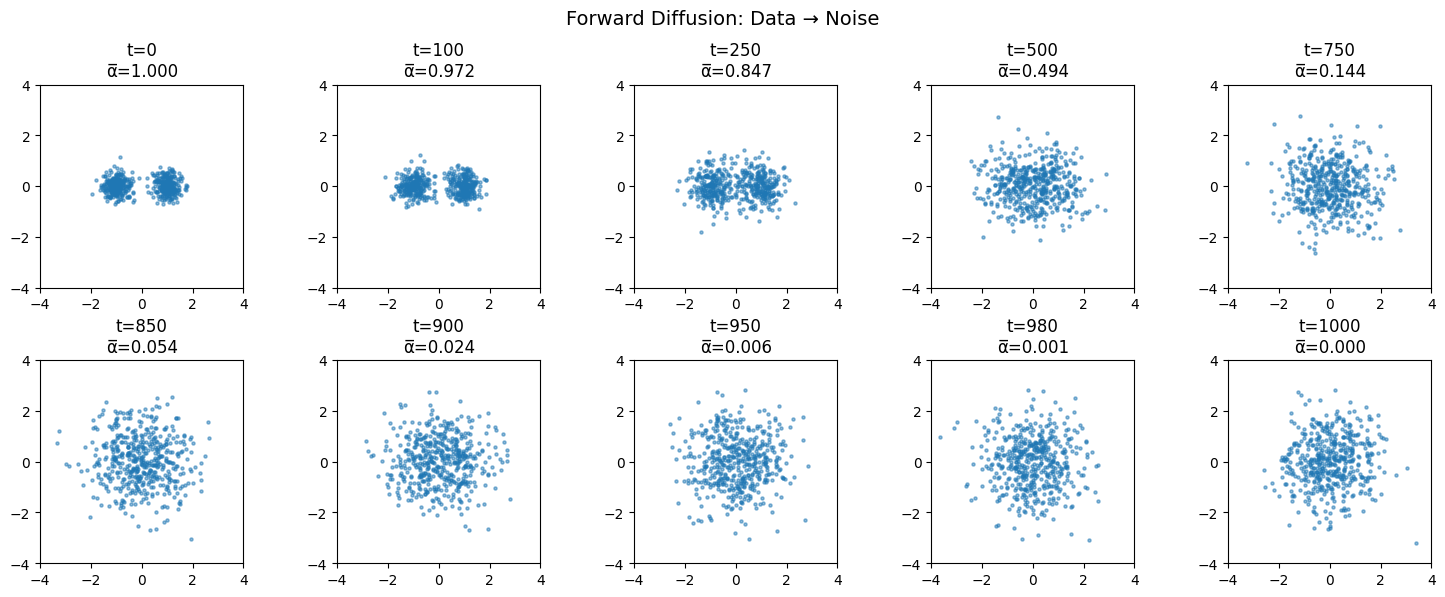

In [5]:
# Visualize the forward process
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
timesteps_to_show = [0, 100, 250, 500, 750, 850, 900, 950, 980, 1000]

for ax, t in zip(axes.flat, timesteps_to_show):
    x_t, _ = add_noise(x_0, t)
    ax.scatter(x_t[:, 0], x_t[:, 1], alpha=0.5, s=5)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title(f't={t}\nα̅={get_alpha_bar(t):.3f}')
    ax.set_aspect('equal')

plt.suptitle('Forward Diffusion: Data → Noise', fontsize=14)
plt.tight_layout()
plt.show()

## 4. What Does the Neural Network Learn?

The network learns to **predict the noise** that was added.

Given:
- $x_t$ (noisy data)
- $t$ (timestep)

Predict:
- $\epsilon$ (the noise that was added)

**Training Loss**: 
$$L = ||\epsilon - \epsilon_\theta(x_t, t)||^2$$

Simple MSE between true noise and predicted noise!

In [6]:
# Pseudo-code for training:

# for each training step:
#     1. Sample real data: x_0 ~ data
#     2. Sample random timestep: t ~ Uniform(0, T)
#     3. Sample noise: ε ~ N(0, I)
#     4. Create noisy data: x_t = sqrt(α̅_t) * x_0 + sqrt(1-α̅_t) * ε
#     5. Predict noise: ε_pred = network(x_t, t)
#     6. Compute loss: L = MSE(ε_pred, ε)
#     7. Update network weights

print("Training a diffusion model is surprisingly simple!")
print("The network just learns to predict noise.")

Training a diffusion model is surprisingly simple!
The network just learns to predict noise.


## 5. Reverse Process: Removing Noise (Sampling)

To generate new data, we:
1. Start with pure noise: $x_T \sim N(0, I)$
2. For $t = T, T-1, ..., 1$:
   - Predict noise: $\epsilon_{pred} = network(x_t, t)$
   - Estimate original: $x_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \cdot \epsilon_{pred}}{\sqrt{\bar{\alpha}_t}}$
   - Take a small step backward
3. Return $x_0$

## 6. Let's Train a Real Model!

Now let's use our actual implementation on the Iris dataset.

In [7]:
import sys
sys.path.insert(0, '../src')

from diffusion import GaussianDiffusion
from models import MLPDenoiser

from sklearn.datasets import load_iris
from sklearn.preprocessing import QuantileTransformer
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

c:\Users\ydran\workspace\seds\seds500-graduation-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Load and preprocess Iris dataset
iris = load_iris()
X = iris.data  # 150 samples, 4 features

print(f"Dataset shape: {X.shape}")
print(f"Features: {iris.feature_names}")

# Preprocess: Quantile transform to Gaussian, then scale to [-1, 1]
scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = scaler.fit_transform(X)
X_scaled = np.clip(X_scaled, -3, 3) / 3  # Now in [-1, 1]

# Convert to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

print(f"\nAfter preprocessing:")
print(f"Mean: {X_tensor.mean():.4f}")
print(f"Std:  {X_tensor.std():.4f}")
print(f"Range: [{X_tensor.min():.4f}, {X_tensor.max():.4f}]")

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

After preprocessing:
Mean: -0.0002
Std:  0.3443
Range: [-1.0000, 1.0000]


c:\Users\ydran\workspace\seds\seds500-graduation-project\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn(


In [9]:
# Create model and diffusion process
d_in = X_tensor.shape[1]  # 4 features

diffusion = GaussianDiffusion(
    num_timesteps=1000,
    beta_schedule="cosine"
).to(device)

model = MLPDenoiser(
    d_in=d_in,
    hidden_dims=[256, 256, 256],
    dropout=0.0
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 199,300


In [10]:
# Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = DataLoader(TensorDataset(X_tensor), batch_size=32, shuffle=True)

n_epochs = 500
losses = []

model.train()
for epoch in tqdm(range(n_epochs), desc="Training"):
    epoch_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        
        optimizer.zero_grad()
        loss = diffusion.training_loss(model, x)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    losses.append(epoch_loss / len(dataloader))

print(f"Final loss: {losses[-1]:.4f}")

Training: 100%|██████████| 500/500 [00:07<00:00, 64.35it/s]

Final loss: 0.2089


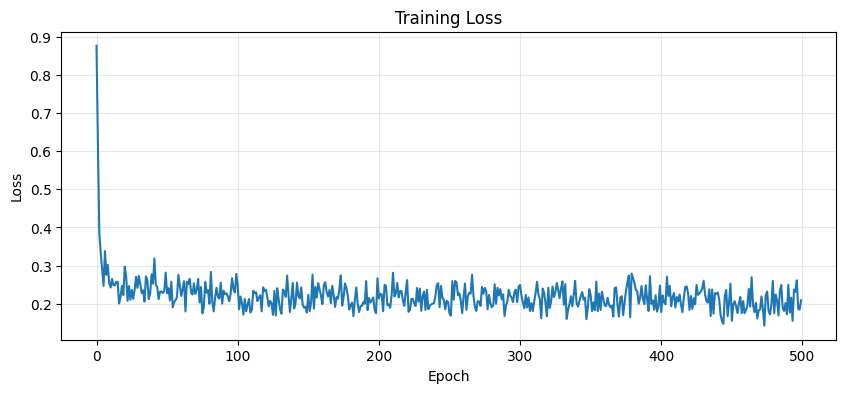

In [11]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Generate synthetic samples
model.eval()
n_samples = 150  # Same as original dataset

with torch.no_grad():
    X_synthetic = diffusion.sample(
        model, 
        shape=(n_samples, d_in),
        device=device
    )

X_synthetic = X_synthetic.cpu().numpy()
print(f"Generated {n_samples} synthetic samples")

Generated 150 synthetic samples


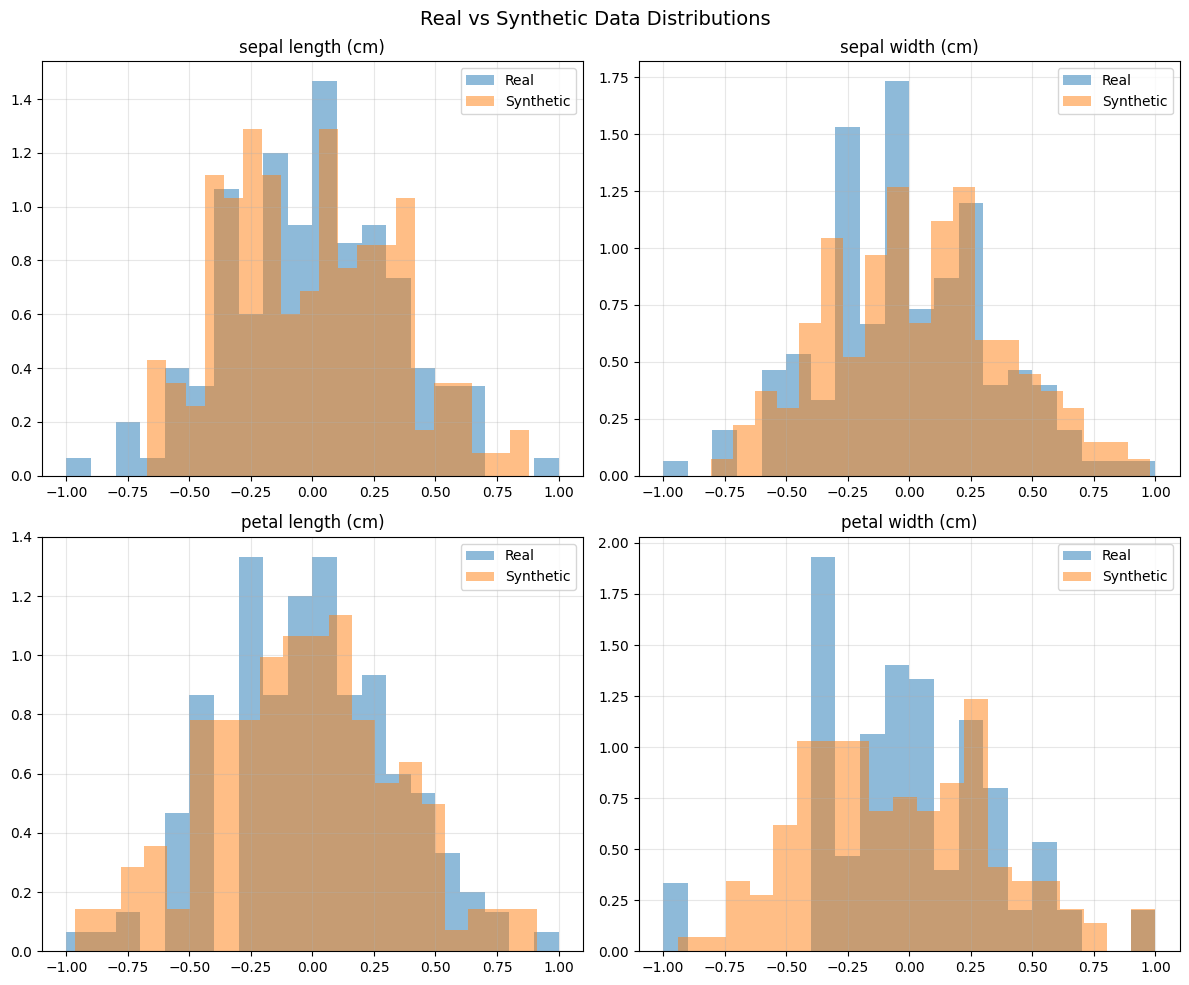

In [13]:
# Compare real vs synthetic distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
feature_names = iris.feature_names

for i, ax in enumerate(axes.flat):
    ax.hist(X_scaled[:, i], bins=20, alpha=0.5, label='Real', density=True)
    ax.hist(X_synthetic[:, i], bins=20, alpha=0.5, label='Synthetic', density=True)
    ax.set_title(feature_names[i])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Real vs Synthetic Data Distributions', fontsize=14)
plt.tight_layout()
plt.show()

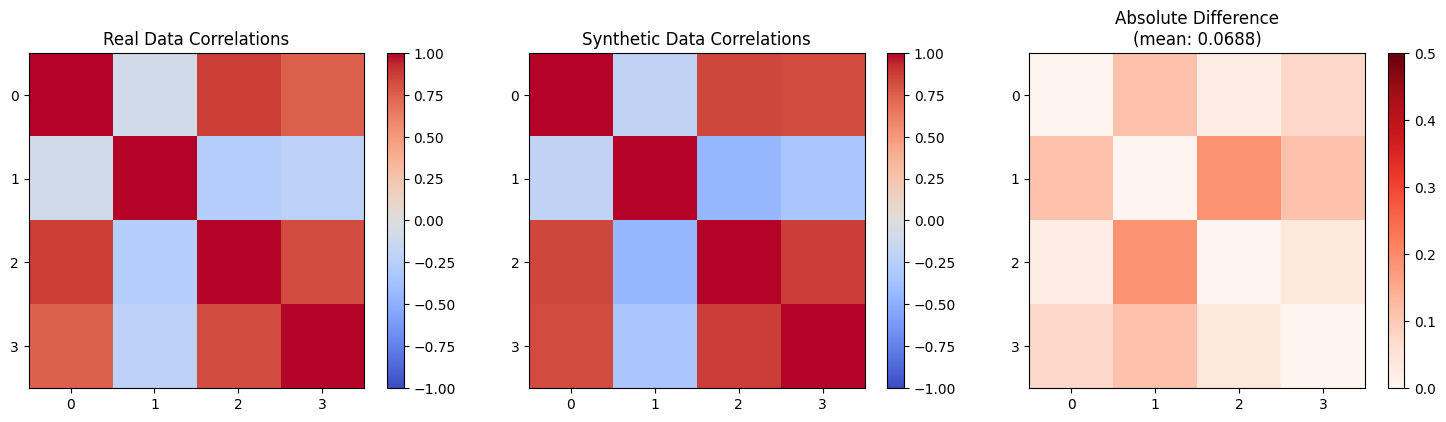

In [14]:
# Compare correlation matrices
real_corr = np.corrcoef(X_scaled.T)
syn_corr = np.corrcoef(X_synthetic.T)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(real_corr, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Real Data Correlations')
axes[0].set_xticks(range(4))
axes[0].set_yticks(range(4))

im2 = axes[1].imshow(syn_corr, cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Synthetic Data Correlations')
axes[1].set_xticks(range(4))
axes[1].set_yticks(range(4))

diff = np.abs(real_corr - syn_corr)
im3 = axes[2].imshow(diff, cmap='Reds', vmin=0, vmax=0.5)
axes[2].set_title(f'Absolute Difference\n(mean: {diff.mean():.4f})')
axes[2].set_xticks(range(4))
axes[2].set_yticks(range(4))

plt.colorbar(im1, ax=axes[0])
plt.colorbar(im2, ax=axes[1])
plt.colorbar(im3, ax=axes[2])
plt.tight_layout()
plt.show()

In [15]:
# Print statistics comparison
print("Statistics Comparison:")
print("=" * 60)
print(f"{'Feature':<20} {'Real Mean':>10} {'Syn Mean':>10} {'Real Std':>10} {'Syn Std':>10}")
print("-" * 60)
for i, name in enumerate(feature_names):
    print(f"{name:<20} {X_scaled[:, i].mean():>10.4f} {X_synthetic[:, i].mean():>10.4f} "
          f"{X_scaled[:, i].std():>10.4f} {X_synthetic[:, i].std():>10.4f}")

Statistics Comparison:
Feature               Real Mean   Syn Mean   Real Std    Syn Std
------------------------------------------------------------
sepal length (cm)       -0.0004    -0.0112     0.3384     0.3408
sepal width (cm)         0.0005     0.0313     0.3390     0.3600
petal length (cm)        0.0007    -0.0473     0.3391     0.3738
petal width (cm)        -0.0015    -0.0408     0.3592     0.3878


## 7. Summary

### What we learned:

1. **Gaussian noise** = random numbers from a bell curve (mean=0, std=1)

2. **Forward process**: Gradually add noise until data becomes pure noise
   - $x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$

3. **Neural network**: Learns to predict the noise that was added
   - Input: noisy data $x_t$ + timestep $t$
   - Output: predicted noise $\epsilon$

4. **Training**: Simple MSE loss between true noise and predicted noise

5. **Sampling**: Start from noise, iteratively remove noise using the trained network

### What's next:
- Handle categorical features (multinomial diffusion)
- Conditional generation (generate specific classes)
- Better evaluation metrics (ML efficiency)